# Sentinel-2 <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
    * One step of the analysis ('Sentinel-2 Near Real Time') is currently only compatible with the DEA Sandbox
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[s2a_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_nrt_granule), 
[s2b_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_nrt_granule)


## Background

Sentinel-2 is an Earth observation mission from the EU Copernicus Programme that systematically acquires optical imagery at high spatial resolution (up to 10 m for some bands).
The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery.
Together, they cover all Earth's land surfaces, large islands, inland and coastal waters every 3-5 days.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [ ]:
import sys
import datacube
from odc.ui import with_ui_cbk

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb

### Connect to the datacube

In [ ]:
dc = datacube.Datacube(app="Sentinel_2")

## Load Sentinel-2 data from the datacube

We will load **Sentinel-2 Definitive** data from the Sentinel-2A and Sentinel-2B satellites using two methods.
Firstly, we will use [dc.load()](../Beginners_guide/04_Loading_data.ipynb) to return a time series of satellite images from a single sensor.
Secondly, we will load a time series using the [load_ard()](../Frequently_used_code/Using_load_ard.ipynb) function, which is a wrapper function around the dc.load module.
This function will load all the images from both Sentinel-2A and Sentinel-2B, combine them, and then apply a cloud mask.
The returned `xarray.Dataset` will contain analysis ready images with the cloudy and invalid pixels masked out.

You can change any of the parameters in the `query` object below to adjust the location, time, projection, or spatial resolution of the returned datasets.
To learn more about querying, refer to the Beginner's guide notebook on [loading data](../Beginners_guide/04_Loading_data.ipynb).

Sentinel-2 data is stored on file with a range of different coordinate reference systems or CRS (i.e. multiple UTM zones). 
The different satellite bands also have different resolutions (10 m, 20 m and 60 m). 
Because of this, all Sentinel-2 queries need to include the following two query parameters:

* `output_crs`: This sets a consistent CRS that all Sentinel-2 data will be reprojected to, regardless of the UTM zone the individual image is stored in.
* `resolution`: This sets the resolution that all Sentinel-2 images will be resampled to. 

> **Note:** Be aware that setting `resolution` to the highest available resolution (i.e. `(-10, 10)`) will downsample the coarser resolution 20 m and 60 m bands, which may introduce unintended artefacts into your analysis.
It is typically best practice to set `resolution` to match the lowest resolution band being analysed. For example, if your analysis uses both 10 m and 20 m resolution bands, set `"resolution": (-20, 20)`.

In [ ]:
# Create a query object
query = {
    "x": (153.45, 153.47),
    "y": (-28.90, -28.92),
    "time": ("2018-01", "2018-02"),
    "output_crs": "EPSG:3577",
    "resolution": (-10, 10),
    "group_by": "solar_day",
}


# Create a query object
query = {
    "x": (122.153716, 122.263580),
    "y": (-18.182218, -18.277437),
    "time": ("2018-01", "2018-02"),
    "output_crs": "EPSG:3577",
    "resolution": (-20, 20),
    "group_by": "solar_day",
}


### Load Sentinel-2 using `dc.load()`

The two **Sentinel-2 Definitive** products are:

* `s2a_ard_granule`
* `s2b_ard_granule`

Here we will load in a time-series of satellite images from only Sentinel-2A.
To load in images from Sentinel-2B, change the `product` variable to `'s2b_ard_granule'`.

In [ ]:
ds = dc.load(product="s2a_ard_granule",
             progress_cbk=with_ui_cbk(),
             **query)

print(ds)

In [ ]:
s2cloudmask.shadow_probs


In [22]:
import numpy as np
import xarray as xr
import s2cloudmask
import datacube
from odc.ui import with_ui_cbk

dc = datacube.Datacube(app='s2cloudmask')

# Load data
ds = dc.load(product='s2a_ard_granule',
             measurements=['nbart_blue', 'nbart_green', 'nbart_red', 
                           'nbart_red_edge_1', 'nbart_red_edge_2', 
                           'nbart_red_edge_3', 'nbart_nir_1', 'nbart_nir_2', 
                           'nbart_swir_2', 'nbart_swir_3'],
#              x=(149.12, 149.17),
#              y=(-35.27, -35.31),
             x=(122.153716, 122.263580),
             y=(-18.182218, -18.277437),
             time=('2018-09', '2018-12'),
             output_crs='EPSG:3577',
             resolution=(-20, 20),
             group_by='solar_day',
             progress_cbk=with_ui_cbk())


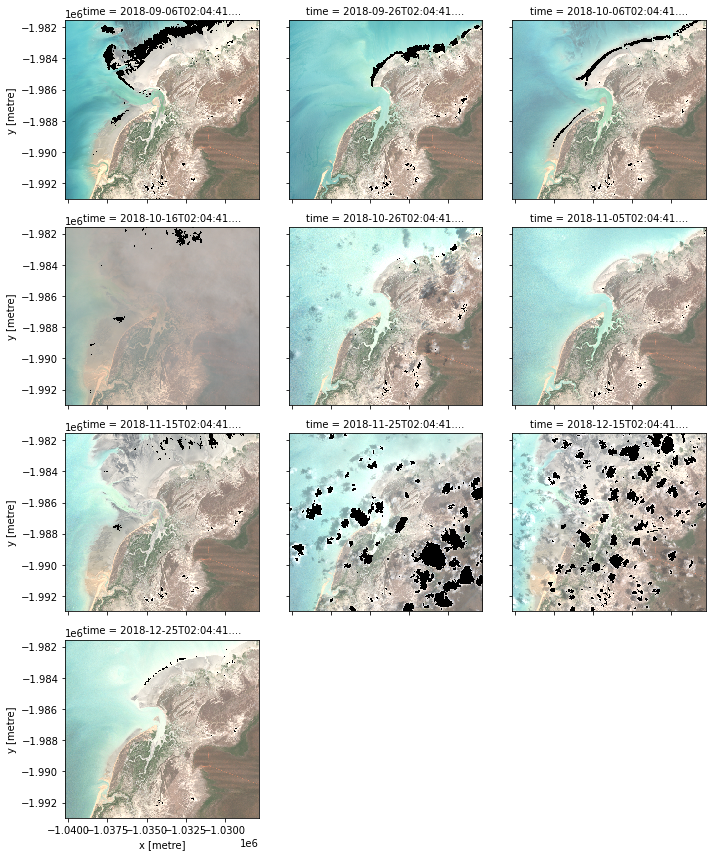

In [38]:
# # Convert to numpy ndarray
# ds_array = ds.to_array().values

# # Rearrange band order to (y, x, bands, time)
# ds_array = ds_array.transpose(2, 3, 0, 1)

# # Set to float, fix NaN and clip to 10000
# ds_array = ds_array.astype(np.float32)
# ds_array[ds_array == -999] = np.nan
# ds_array = ds_array.clip(0, 10000)
# ds_array /= 10000.

# # Run classifier
# # mask_array = ~s2cloudmask.cloud_mask(ds_array, model='spectral')
# cloud_array = s2cloudmask.cloud_probs(ds_array, model='spectral') < 0.50
# shadow_array = s2cloudmask.shadow_probs(ds_array, model='spectral') < 0.50
mask_array = shadow_array | cloud_array

# Convert output to xarray
mask_da = xr.DataArray(mask_array, dims=['y', 'x', 'time'], 
                       coords={'x': ds.x, 'y': ds.y, 'time': ds.time})

# Plot masked data
rgb_bands = ['nbart_red', 'nbart_green', 'nbart_blue']
(ds[rgb_bands] ** 0.5).where(mask_da, 0).to_array().plot.imshow(
    robust=True, col='time', col_wrap=3)

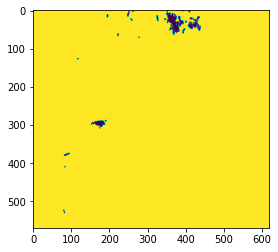

In [42]:
import matplotlib.pyplot as plt
plt.imshow(shadow_array[..., 3])

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)